# Data Analysis on YOC start-up 

## YOC is a cab riding start-up  named Your Own Cab which had launched its project in Jan 2020. Now we are having one year of data and will do some analysis to check the performance in its first year of business.           

In [147]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 
import pandas as pd

In [4]:
spark = SparkSession.builder.appName("yoc_project").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-01-15 17:55:54,633 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Creating the Schema for Bookings and Clickstream data

In [5]:
bookings_schema = StructType([\
                              StructField('booking_id',StringType(),True),\
                              StructField('customer_id',IntegerType(),True),\
                              StructField('driver_id',IntegerType(),True),\
                              StructField('customer_app_version',StringType(),True),\
                              StructField('customer_phone_os_version',StringType(),True),\
                              StructField('pickup_lat',DoubleType(),True),\
                              StructField('pickup_lon',DoubleType(),True),\
                              StructField('drop_lat',DoubleType(),True),\
                              StructField('drop_lon',DoubleType(),True),\
                              StructField('pickup_timestamp',StringType(),True),\
                              StructField('drop_timestamp',StringType(),True),\
                              StructField('trip_fare',FloatType(),True),\
                              StructField('tip_amount',FloatType(),True),\
                              StructField('currency_code',StringType(),True),\
                              StructField('cab_color',StringType(),True),\
                              StructField('cab_registration_no',StringType(),True),\
                              StructField('customer_rating_by_driver',IntegerType(),True),\
                              StructField('rating_by_customer',IntegerType(),True),\
                              StructField('passenger_count',IntegerType(),True)])
    


In [6]:
clickstream_schema = StructType([StructField('customer_id',IntegerType(),True),\
                              StructField('app_version',StringType(),True),\
                              StructField('OS_version',StringType(),True),\
                              StructField('lat',DoubleType(),True),\
                              StructField('lon',DoubleType(),True),\
                              StructField('page_id',StringType(),True),\
                              StructField('button_id',StringType(),True),\
                              StructField('is_button_click',StringType(),True),\
                              StructField('is_page_view',StringType(),True),\
                              StructField('is_scroll_up',StringType(),True),\
                              StructField('is_scroll_down',StringType(),True),\
                              StructField('timestamp',StringType(),True)])

### Loading bookings and clickstream data from hdfs to spark

In [7]:
bookings=spark.read.format('csv').schema(bookings_schema).load("hdfs://localhost:54310/yoc_project/bookings/part*")

In [8]:
clickstream=spark.read.\
csv("hdfs://localhost:54310/yoc_project/clickstream/clickstream.csv",header=False,schema=clickstream_schema)

# Take a glance at bookings data

In [11]:
bookings.columns


['booking_id',
 'customer_id',
 'driver_id',
 'customer_app_version',
 'customer_phone_os_version',
 'pickup_lat',
 'pickup_lon',
 'drop_lat',
 'drop_lon',
 'pickup_timestamp',
 'drop_timestamp',
 'trip_fare',
 'tip_amount',
 'currency_code',
 'cab_color',
 'cab_registration_no',
 'customer_rating_by_driver',
 'rating_by_customer',
 'passenger_count']

In [55]:
bookings.describe().toPandas()

,summary,booking_id,customer_id,driver_id,customer_app_version,customer_phone_os_version,pickup_lat,pickup_lon,drop_lat,drop_lon,pickup_timestamp,drop_timestamp,trip_fare,tip_amount,currency_code,cab_color,cab_registration_no,customer_rating_by_driver,rating_by_customer,passenger_count
0,count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,mean,None,5.7293605363E7,5.5185378184E7,None,None,-0.02258811399999921,0.9523736479999997,2.1092333430000005,-0.2716544600000024,None,None,512.563,51.021,None,None,None,3.037,2.968,2.534
2,stddev,None,2.5736510705042005E7,2.5924210489723753E7,None,None,51.503800643647814,102.77256975700413,51.09454833601444,103.63751282466721,None,None,283.22415849456564,29.12725452142641,None,None,None,1.4218483226605612,1.3967558580249182,1.1027511324229327
3,min,BK100000018,10022393,10041826,1.1.1,Android,-89.8118755,-179.62995,-89.9900655,-179.177221,2020-01-01 13:57:47.0,2020-01-02 04:16:57.0,25.0,1.0,INR,aqua,001-05-9678,1,1,1
4,max,BK9996514884,99947969,99815381,4.4.8,iOS,89.964237,179.695812,89.6034155,179.871154,2020-10-26 23:46:58.0,2020-10-27 16:12:31.0,998.0,100.0,INR,yellow,897-85-6044,5,5,4


### Aggregating total bookings date-wise

In [75]:
aggregated_bookings=bookings.select(to_date(col('pickup_timestamp')).alias('date')).\
groupBy('date').agg(count(col('date')).alias('bookings')).sort('date').toPandas()

In [76]:
aggregated_bookings

,date,bookings
0,2020-01-01,1
1,2020-01-02,3
2,2020-01-03,2
3,2020-01-04,2
4,2020-01-05,2
...,...,...
284,2020-10-22,3
285,2020-10-23,1
286,2020-10-24,3
287,2020-10-25,5


### Aggregating total bookings cab_color-wise

In [82]:
bookings_cab_color_wise=bookings.groupBy('cab_color').agg(count(col('cab_color')).alias('bookings')).toPandas()

In [83]:
bookings_cab_color_wise

,cab_color,bookings
0,green,74
1,yellow,71
2,silver,71
3,purple,68
4,white,74
5,gray,61
6,lime,53
7,aqua,61
8,maroon,70
9,olive,70


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Color-Wise Cab Bookings')

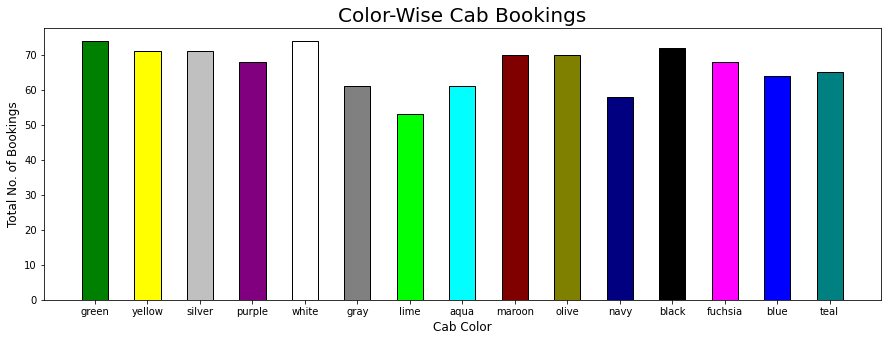

In [116]:
fig, ax =plt.subplots(figsize=(15,5))
plt.bar(bookings_cab_color_wise['cab_color'],bookings_cab_color_wise['bookings'],\
        width=0.5,color=bookings_cab_color_wise['cab_color'],edgecolor='black')
plt.xlabel('Cab Color',fontsize=12)
plt.ylabel('Total No. of Bookings',fontsize=12)
plt.title('Color-Wise Cab Bookings',fontsize=20)

### Aggregating bookings month and cab_color-wise

In [117]:
bookings_month_cab_color_wise=bookings.select((date_format(to_date(col('pickup_timestamp')),'yyyy-MM')).alias('month'),'cab_color').\
groupBy('month','cab_color').count().sort('month').toPandas()

In [118]:
bookings_month_cab_color_wise

,month,cab_color,count
0,2020-01,lime,6
1,2020-01,yellow,4
2,2020-01,olive,5
3,2020-01,purple,5
4,2020-01,blue,9
...,...,...,...
144,2020-10,maroon,7
145,2020-10,blue,2
146,2020-10,white,5
147,2020-10,gray,3


### Aggregating tip_amount for each month

In [150]:
tip_aggregation=bookings.select('tip_amount',date_format(to_date(col('pickup_timestamp')),'yyyy-MM').alias('month')).\
groupBy('month').agg(sum('tip_amount').alias('tip_amount')).sort('month').toPandas()

In [151]:
tip_aggregation

,month,tip_amount
0,2020-01,4787.0
1,2020-02,4860.0
2,2020-03,4866.0
3,2020-04,5765.0
4,2020-05,5151.0
5,2020-06,4960.0
6,2020-07,4940.0
7,2020-08,6343.0
8,2020-09,4982.0
9,2020-10,4367.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Tip Amount Monthly')

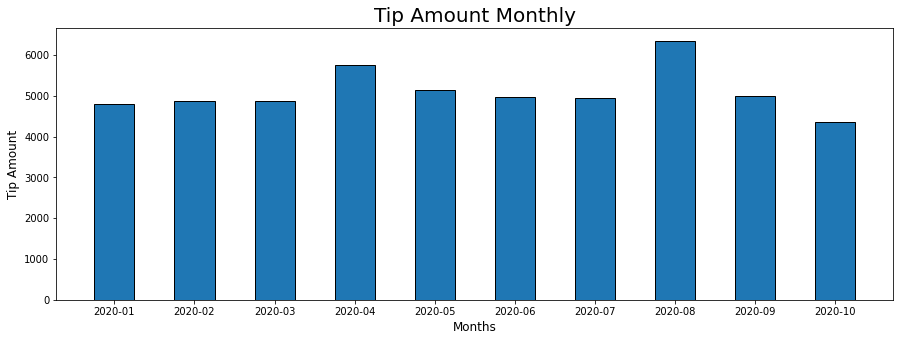

In [152]:
fig, ax =plt.subplots(figsize=(15,5))
plt.bar(tip_aggregation['month'],tip_aggregation['tip_amount'],\
        width=0.5,edgecolor='black')
plt.xlabel('Months',fontsize=12)
plt.ylabel('Tip Amount',fontsize=12)
plt.title('Tip Amount Monthly',fontsize=20)

### Aggregating total trip_fare for each month 

In [153]:
fare_aggregation=bookings.select('trip_fare',date_format(to_date(col('pickup_timestamp')),'yyyy-MM').alias('month')).\
groupBy('month').agg(sum('trip_fare').alias('trip_fare')).sort('month').toPandas()

In [154]:
fare_aggregation.sort_values("month")

,month,trip_fare
0,2020-01,48574.0
1,2020-02,52607.0
2,2020-03,48784.0
3,2020-04,58223.0
4,2020-05,48434.0
5,2020-06,45644.0
6,2020-07,57419.0
7,2020-08,54023.0
8,2020-09,53063.0
9,2020-10,45792.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Trip Fare Monthly')

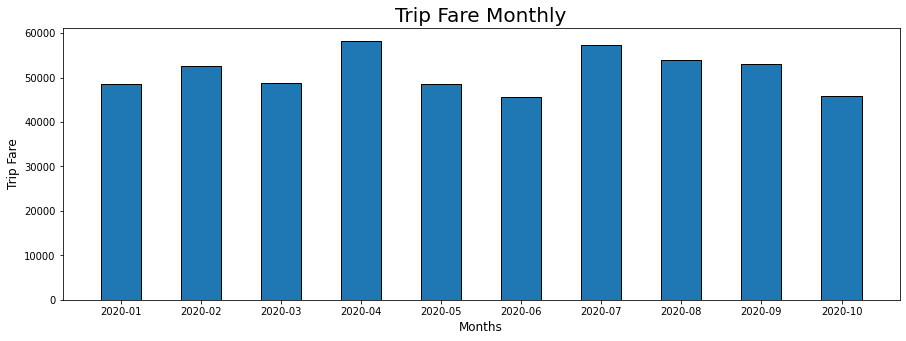

In [155]:
fig, ax =plt.subplots(figsize=(15,5))
plt.bar(fare_aggregation['month'],fare_aggregation['trip_fare'],\
        width=0.5,edgecolor='black')
plt.xlabel('Months',fontsize=12)
plt.ylabel('Trip Fare',fontsize=12)
plt.title('Trip Fare Monthly',fontsize=20)

### Aggregating bookings having rating_by_customer greater than 3 for each month

In [159]:
high_rating_bookings=bookings.filter(col('rating_by_customer')>3).\
select((date_format(to_date(col('pickup_timestamp')),'yyyy-MM').alias('month'))).\
groupBy('month').agg(count(col('month')).alias('bookings')).sort('month').toPandas()

In [160]:
high_rating_bookings

,month,bookings
0,2020-01,38
1,2020-02,35
2,2020-03,36
3,2020-04,55
4,2020-05,37
5,2020-06,30
6,2020-07,43
7,2020-08,42
8,2020-09,37
9,2020-10,36


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Higher Rated Monthly Bookings')

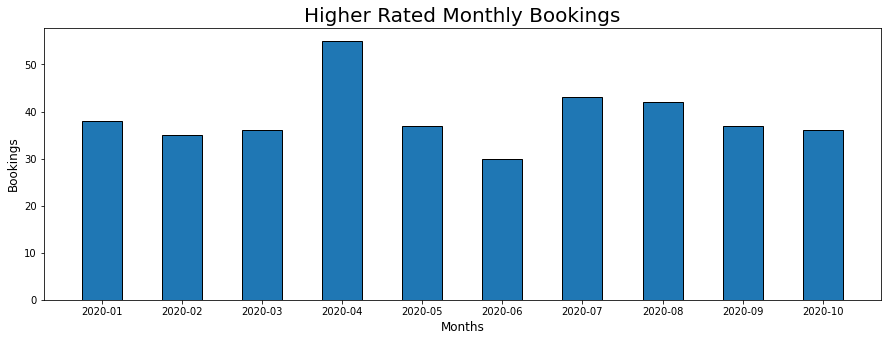

In [161]:
fig, ax =plt.subplots(figsize=(15,5))
plt.bar(high_rating_bookings['month'],high_rating_bookings['bookings'],\
        width=0.5,edgecolor='black')
plt.xlabel('Months',fontsize=12)
plt.ylabel('Bookings',fontsize=12)
plt.title('Higher Rated Monthly Bookings',fontsize=20)

### Aggregating total number of drivers for each of the customer rating

In [162]:
customer_ratings=bookings.groupBy('rating_by_customer').agg(count(col('rating_by_customer')).alias('drivers')).\
sort('rating_by_customer').toPandas()

In [163]:
customer_ratings

,rating_by_customer,drivers
0,1,202
1,2,201
2,3,208
3,4,205
4,5,184


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

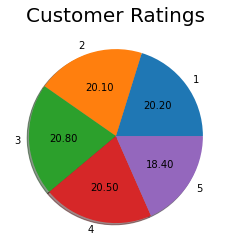

In [175]:
plt.pie(customer_ratings['drivers'],
        labels=customer_ratings['rating_by_customer'],
       shadow=True,autopct= '%.2f')
plt.title('Customer Ratings',fontsize=20)
plt.show()

### Aggregating on OS Version

In [177]:
os_grouping=bookings.groupBy('customer_phone_os_version').\
agg(count(col('customer_phone_os_version')).alias('freq')).toPandas()

In [178]:
os_grouping

,customer_phone_os_version,freq
0,iOS,521
1,Android,479


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

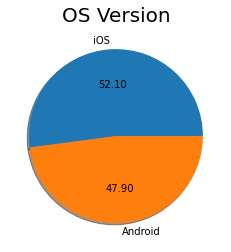

In [180]:
plt.pie(os_grouping['freq'],
        labels=os_grouping['customer_phone_os_version'],
       shadow=True,autopct= '%.2f')
plt.title('OS Version',fontsize=20)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'OS Version')

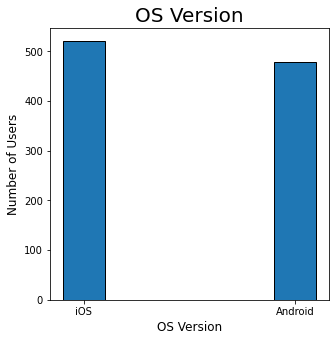

In [190]:
fig, ax =plt.subplots(figsize=(5,5))
plt.bar(os_grouping['customer_phone_os_version'],os_grouping['freq'],\
        width=0.2,edgecolor='black')
plt.xlabel('OS Version',fontsize=12)
plt.ylabel('Number of Users',fontsize=12)
plt.title('OS Version',fontsize=20)

# Take a glance at clickstream data

In [59]:
clickstream.columns

['customer_id',
 'app_version',
 'OS_version',
 'lat',
 'lon',
 'page_id',
 'button_id',
 'is_button_click',
 'is_page_view',
 'is_scroll_up',
 'is_scroll_down',
 'timestamp']

In [21]:
clickstream.toPandas()

,customer_id,app_version,OS_version,lat,lon,page_id,button_id,is_button_click,is_page_view,is_scroll_up,is_scroll_down,timestamp
0,26564820,3.2.35,Android,16.445487,99.902065,de545711-3914-4450-8c11-b17b8dabb5e1,fcba68aa-1231-11eb-adc1-0242ac120002,No,Yes,No,Yes,2020-09-14 09:59:07
1,31906387,2.4.7,iOS,-64.813749,-133.527040,de545711-3914-4450-8c11-b17b8dabb5e1,a95dd57b-779f-49db-819d-b6960483e554,No,No,Yes,Yes,2020-05-16 16:30:21
2,25713677,3.4.12,Android,89.943435,127.313415,b328829e-17ae-11eb-adc1-0242ac120002,fcba68aa-1231-11eb-adc1-0242ac120002,No,No,Yes,No,2020-02-09 00:52:13
3,83474293,3.1.8,Android,-69.939070,-36.451670,e7bc5fb2-1231-11eb-adc1-0242ac120002,e1e99492-17ae-11eb-adc1-0242ac120002,Yes,No,Yes,No,2020-06-17 10:42:50
4,63727807,2.2.9,iOS,64.082108,-81.822078,e7bc5fb2-1231-11eb-adc1-0242ac120002,fcba68aa-1231-11eb-adc1-0242ac120002,No,Yes,Yes,Yes,2020-07-06 02:51:53
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16813062,3.2.18,Android,-88.342371,-176.291730,b328829e-17ae-11eb-adc1-0242ac120002,e1e99492-17ae-11eb-adc1-0242ac120002,No,Yes,No,No,2020-05-05 23:08:24
2996,13307480,4.3.36,iOS,26.664538,109.842184,b328829e-17ae-11eb-adc1-0242ac120002,e1e99492-17ae-11eb-adc1-0242ac120002,No,Yes,Yes,Yes,2020-06-12 19:23:21
2997,66537285,3.4.37,Android,-43.480471,108.716577,de545711-3914-4450-8c11-b17b8dabb5e1,e1e99492-17ae-11eb-adc1-0242ac120002,Yes,Yes,No,Yes,2020-09-07 17:10:58
2998,48434687,4.1.28,Android,-7.888734,-54.732169,b328829e-17ae-11eb-adc1-0242ac120002,a95dd57b-779f-49db-819d-b6960483e554,Yes,Yes,No,No,2020-02-18 19:48:48


### Calculating the conversion ratio (total number of visits on 'Booking Page'/ total number of bookings done)

In [22]:
# Booking page_id is e7bc5fb2-1231-11eb-adc1-0242ac120002

total_booking_page_visits=clickstream.\
filter((col('page_id')=="e7bc5fb2-1231-11eb-adc1-0242ac120002") & (col('is_page_view')=="Yes")).count()

In [23]:
total_booking_page_visits

513

In [24]:
# Book Now button_id is fcba68aa-1231-11eb-adc1-0242ac120002

total_bookings=clickstream.\
filter((col('button_id')=="fcba68aa-1231-11eb-adc1-0242ac120002") & (col('is_button_click')=="Yes")).count()

In [25]:
total_bookings

497

In [26]:
total_bookings/total_booking_page_visits

0.9688109161793372

##### As we can see from the above result that conversion ratio is 96.88% which is a very good percentage 

## Now we can do some more analysis on this data

### check how many user from different platform are viewing the Booking page

In [200]:
view_page=clickstream.filter((col('page_id')=="e7bc5fb2-1231-11eb-adc1-0242ac120002")).\
groupBy('OS_version','is_page_view').agg(count(col('is_page_view')).alias('page_visit_count')).sort('OS_version').toPandas()

In [201]:
view_page

,OS_version,is_page_view,page_visit_count
0,Android,No,240
1,Android,Yes,269
2,iOS,Yes,244
3,iOS,No,261


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

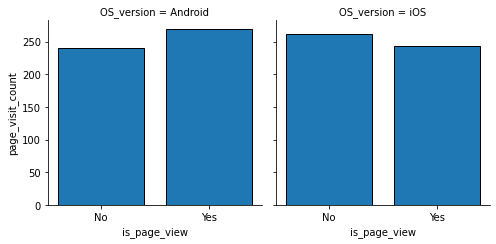

In [228]:

g=sns.FacetGrid(view_page,col='OS_version',height=3.5)
g.map(plt.bar,'is_page_view','page_visit_count',edgecolor='black')

plt.show()

### check how many user from different platform are actually booking the rides

In [211]:
rides_booked=clickstream.filter((col('button_id')=="fcba68aa-1231-11eb-adc1-0242ac120002")).\
groupBy('OS_version','is_button_click').agg(count(col('is_button_click')).alias('freq')).\
sort('OS_version','is_button_click').toPandas()

In [212]:
rides_booked

,OS_version,is_button_click,freq
0,Android,No,253
1,Android,Yes,248
2,iOS,No,249
3,iOS,Yes,249


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

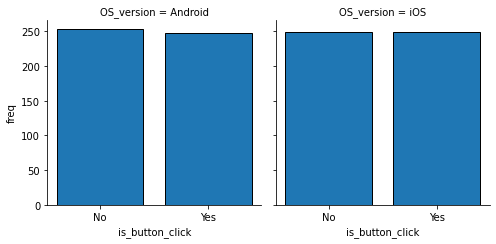

In [229]:
g=sns.FacetGrid(rides_booked,col='OS_version',height=3.5)
g.map(plt.bar,'is_button_click','freq',edgecolor='black')
plt.show()

In [230]:
page_view=clickstream.filter(col('is_page_view')=="Yes").groupBy('page_id','is_page_view').\
agg(count(col('is_page_view')).alias('count')).toPandas()

In [231]:
page_view

,page_id,is_page_view,count
0,e7bc5fb2-1231-11eb-adc1-0242ac120002,Yes,513
1,b328829e-17ae-11eb-adc1-0242ac120002,Yes,479
2,de545711-3914-4450-8c11-b17b8dabb5e1,Yes,520


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Number of Views per Page')

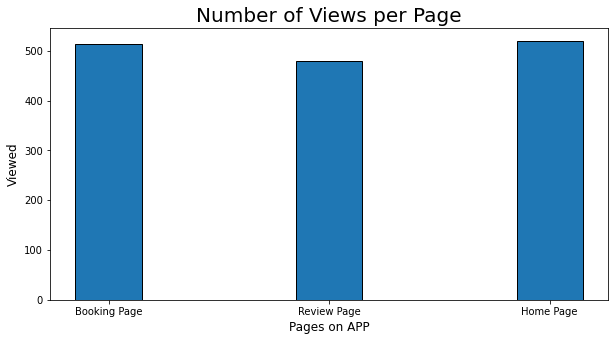

In [233]:
fig, ax =plt.subplots(figsize=(10,5))
plt.bar(['Booking Page','Review Page','Home Page'],page_view['count'],\
        width=0.3,edgecolor='black')
plt.xlabel('Pages on APP',fontsize=12)
plt.ylabel('Viewed',fontsize=12)
plt.title('Number of Views per Page',fontsize=20)